<a href="https://colab.research.google.com/github/rohh-silvaa/PLN/blob/main/Rodrigo_Almeida_e_Nat%C3%A1lia_Souza_2025_Q3_PLN_PROJETO_PR%C3%81TICO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Processamento de Linguagem Natural - Projeto Final [2025-Q3]**
Prof. Alexandre Donizeti Alves

### **EQUIPE**

---

**Integrante 01:**

Natalia de Cássia Souza RA: 11202410017

**Integrante 02:**

Rodrigo da Silva Almeida RA: 11202131701



### **GRANDE MODELO DE LINGUAGEM (*Large Language Model - LLM*)**

---



**LLM**: Gemini

>

**Link para a documentação oficial**: https://ai.google.dev/gemini-api/docs/models?hl=pt-br



### **API**
---

**API**: News API

**Site oficial**: https://newsapi.org/

**Link para a documentação oficial**: https://newsapi.org/docs






# **DESCRIÇÃO**

Implementar um `notebook` no `Google Colab` que faça uso do framework **`LangChain`** (obrigatório) e de um **LLM** aplicando, no mínimo, DUAS técnicas de PLN. As técnicas podem ser aplicada em qualquer córpus obtido a partir de uma **API** ou a partir de uma página Web.


As seguintes técnicas de PLN podem ser usadas:

*   Correção Gramatical
*   Classificação de Textos
*  **Análise de Sentimentos**
*   Detecção de Emoções
*   Extração de Palavras-chave
*   Tradução de Textos
*   Sumarização de Textos
*   Similaridade de Textos
*   **Reconhecimento de Entidades Nomeadas**
*   Sistemas de Perguntas e Respostas



# **NOSSO PROJETO**

Nosso projeto utiliza a base de dados disponibilizada pela **API NewsAPI** para coletar notícias a partir de consultas definidas pelo usuário. A partir desse conjunto de manchetes, são extraídas automaticamente as **entidades presentes em cada notícia**, como pessoas, organizações e locais relevantes. Em seguida, é realizada uma **análise de sentimentos** associada a cada entidade identificada, permitindo avaliar a polaridade das notícias em torno desses elementos.

Por fim, os resultados são organizados em tabelas, o que facilita uma visualização estruturada dos dados e uma análise mais aprofundada dos padrões observados.

### **IMPLEMENTAÇÃO**
---

Realizamos a instalação das bibliotecas necessárias para o projeto.

A ***langchain-google-genai*** será utilizada para integração com os modelos de IA da Google, a ***newsapi-python*** para acessar e consultar notícias pela NewsAPI, a pydantic para estruturar e validar dados ao longo do fluxo, e a ***pandas*** para organizar e analisar os resultados em forma de tabelas dentro do notebook.

In [1]:
!pip install -qU langchain-google-genai newsapi-python pydantic pandas



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.9.0 which is incompatible.
gradio 5.50.0 requires pydantic<=2.12

Neste bloco, são importadas as bibliotecas e classes que serão utilizadas no projeto.

In [6]:
import os
import pandas as pd
from newsapi import NewsApiClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import List, Literal
from google.colab import userdata

 Configuramos as variáveis de ambiente necessárias para o uso das APIs.

In [7]:
API_KEY = userdata.get("GOOGLE_API_KEY")

if "NEWS_API_KEY" not in os.environ:
   os.environ["NEWS_API_KEY"] = userdata.get('NEWS_API_KEY')


#**Neste bloco, definimos os modelos de dados que irão representar o resultado da análise feita pelo modelo de IA.**

A classe ***EntidadeDetectada*** descreve cada entidade identificada na notícia, incluindo seu nome, tipo (pessoa, organização, local ou outro) e o sentimento associado a ela (positivo, negativo ou neutro).

Já a classe ***AnaliseNoticia*** agrupa a lista de entidades extraídas, um resumo da notícia e uma opinião geral sobre o conteúdo, fornecendo uma estrutura padronizada para os retornos de análise.

In [8]:
class EntidadeDetectada(BaseModel):
    nome: str = Field(description="Nome da entidade (ex.: pessoa, organização, local, conceito, produto etc.)")
    tipo: Literal['Pessoa', 'Organizacao', 'Local', 'Outro'] = Field(description="Categoria da entidade")
    sentimento: Literal['positivo', 'negativo', 'neutro'] = Field(description="O tom da notícia especificamente sobre esta entidade")

class AnaliseNoticia(BaseModel):
    entidades: List[EntidadeDetectada]
    resumo: str
    opiniao: str = Field(description="Opinião geral do modelo sobre a notícia")

#**Agora, configuramos o modelo de linguagem e o prompt que serão usados na análise automática das notícias.**

O objeto ***llm*** é criado com o ***ChatGoogleGenerativeAI***, utilizando o modelo ***gemini-2.5-flash*** com temperatura 0 e a capacidade de retornar a saída já estruturada no formato da classe AnaliseNoticia. Em seguida, o ***ChatPromptTemplate*** define as instruções detalhadas para o modelo, incluindo a ***detecção de entidades*** (NER), a ***análise de sentimento por entidade*** (ABSA), a geração de um resumo e uma opinião crítica sobre o texto da notícia fornecido.

In [58]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    temperature=0,
    google_api_key=API_KEY
).with_structured_output(AnaliseNoticia)

prompt = ChatPromptTemplate.from_template(
    """
    Você é um especialista em Processamento de Linguagem Natural (PLN).
    Realize as seguintes tarefas no texto abaixo:

    1. NER (Reconhecimento de Entidades): Identifique os principais atores.
       - Para pessoas, SEMPRE use o nome completo mais conhecido da entidade.
       - Evite duplicatas: se aparecerem formas abreviadas.
    2. ABSA: Analise o sentimento de cada entidade.
    3. Gere um resumo curto da notícia.
    4. Dê uma opinião crítica, objetiva e equilibrada sobre a notícia (3 a 5 linhas).

    Texto da Notícia:
    {texto_noticia}
    """
)



#**Configuramos a cadeia principal de processamento usando ***LangChain***.**

*   O objeto ***llm*** representa o modelo de linguagem Gemini configurado para retornar a saída no formato da classe AnaliseNoticia. Em seguida, o ChatPromptTemplate define o texto-base das instruções que será combinado com o conteúdo de cada notícia.
*   Juntos, prompt e llm formam a base da cadeia que será usada posteriormente para analisar automaticamente as manchetes.


In [64]:
chain = prompt | llm

#**Neste bloco, definimos a função ***buscarNoticia***, que é o ponto de entrada para coletar notícias da NewsAPI.**

Ela recebe um termo de busca e o número de resultados desejados, inicializa o cliente da API, faz uma consulta para artigos em português ordenados por popularidade e filtra entradas inválidas (como títulos removidos).

Os dados são processados em um DataFrame do pandas, extraindo data, título e um conteúdo combinado (título + descrição) para análise posterior, além da url de cada notícia.

In [60]:
def buscarNoticia(termo, tamanho):
    print(f" Buscando notícias sobre '{termo}'...")
    newsapi = NewsApiClient(api_key=os.environ.get("NEWS_API_KEY"))

    response = newsapi.get_everything(
        q=termo,
        language='pt',
        sort_by='popularity',
        page_size=tamanho
    )

    dados_brutos = []
    for artigo in response['articles']:
        if artigo['title'] == "[Removed]": continue

        dados_brutos.append({
            'data': artigo['publishedAt'][:10],
            'titulo': artigo['title'],
            'conteudo_completo': f"{artigo['title']}. {artigo['description'] or ''}",
            'url': artigo['url']
        })

    return pd.DataFrame(dados_brutos)

# **Agora, definimos o tema de interesse para a coleta de notícias e executamos a função de busca.**

A variável tema_escolhido concentra os termos que serão usados na consulta à NewsAPI, enquanto df_inicial = buscarNoticia(...) retorna um DataFrame com as notícias encontradas sobre o tema, limitado à quantidade especificada. Em seguida, exibimos o número total de notícias coletadas e visualizamos as primeiras linhas do conjunto de dados para inspeção inicial.



In [61]:
tema_escolhido = "Bolsonaro AND Prisão"  # Você pode mudar o tema aqui
df_inicial = buscarNoticia(termo=tema_escolhido, tamanho=11)

print(f"\nColeta finalizada. Foram encontradas {len(df_inicial)} notícias.")
display(df_inicial.head(10))

 Buscando notícias sobre 'Bolsonaro AND Prisão'...

Coleta finalizada. Foram encontradas 10 notícias.


,data,titulo,conteudo_completo,url
0,2025-11-22,"'É uma pena', diz Trump sobre a prisão de Bolsonaro","'É uma pena', diz Trump sobre a prisão de Bolsonaro. Presidente americano e aliado de Bolsonaro falou brevemente com jornalistas sobre a prisão ocorrida neste sábado (22/11).",https://www.bbc.com/portuguese/articles/c9qevg9q141o
1,2025-11-22,Como imprensa internacional noticia prisão preventiva de Bolsonaro,"Como imprensa internacional noticia prisão preventiva de Bolsonaro. The Washington Post destacou que ""assim como a maioria de seus colegas"" do STF, Moraes ""raramente toma decisões aos sábados, a menos que haja riscos de segurança envolvidos"".",https://www.bbc.com/portuguese/articles/cn419d1kj92o
2,2025-11-23,"Decisão de Moraes foi 'prudente', e Bolsonaro fica mais perto de cumprir pena na cadeia, analisam especialistas","Decisão de Moraes foi 'prudente', e Bolsonaro fica mais perto de cumprir pena na cadeia, analisam especialistas. Segundo juristas, será ainda mais difícil para a defesa de Jair Bolsonaro conseguir que ele cumpra sua pena em prisão domiciliar agora",https://www.bbc.com/portuguese/articles/c8jwl42mymro
3,2025-11-23,Embaixada dos EUA no Brasil critica prisão de Bolsonaro: 'Provocativa e desnecessária',"Embaixada dos EUA no Brasil critica prisão de Bolsonaro: 'Provocativa e desnecessária'. Em post nas redes sociais, embaixada dos EUA no Brasil chama Moraes de “violador de direitos humanos” e critica prisão de Bolsonaro",https://www.bbc.com/portuguese/articles/cn8eyzgxjeyo
4,2025-11-28,"Sem líder claro, direita está dividida após prisão de Bolsonaro, diz Economist","Sem líder claro, direita está dividida após prisão de Bolsonaro, diz Economist. Revista britânica diz que ""o maior beneficiário do legado caótico de Bolsonaro é Lula"".",https://www.bbc.com/portuguese/articles/clykeq2q44jo
5,2025-11-25,"Bolsonaro está preocupado com origem da comida na prisão, diz Flávio","Bolsonaro está preocupado com origem da comida na prisão, diz Flávio. Ex-presidente começou a cumprir pena de 27 anos de prisão em sala de Estado na Polícia Federal",https://www.bbc.com/portuguese/articles/c62n4ejl00jo
6,2025-11-21,Moraes decreta prisão de Ramagem; o que se sabe,Moraes decreta prisão de Ramagem; o que se sabe. Deputado federal e ex-diretor da Abin saiu do Brasil em setembro e se encontra nos EUA,https://www.bbc.com/portuguese/articles/c5y236dv91yo
7,2025-11-24,O que a imprensa internacional falou sobre episódio com tornozeleira eletrônica de Bolsonaro,O que a imprensa internacional falou sobre episódio com tornozeleira eletrônica de Bolsonaro. Bolsonaro admitiu ter utilizado um ferro de solda durante a madrugada de sábado para tentar violar a tornozeleira.,https://www.bbc.com/portuguese/articles/c3w7pvl5vxyo
8,2025-11-22,Jair Bolsonaro é preso preventivamente pela Polícia Federal,"Jair Bolsonaro é preso preventivamente pela Polícia Federal. Segundo fontes da Polícia Federal ouvidas pela BBC News Brasil, até o momento não há indicação de descumprimento de medidas cautelares",https://www.bbc.com/portuguese/articles/c0ed82q97wqo
9,2025-11-22,"'Eu pedi para ele não desistir de nós', diz Michelle Bolsonaro sobre a prisão do marido","'Eu pedi para ele não desistir de nós', diz Michelle Bolsonaro sobre a prisão do marido. Ex-primeira-dama pede que rezem também ""por nossos inimigos, por aqueles que nos perseguem"", e cita nominalmente o ministro Alexandre de Moraes",https://www.bbc.com/portuguese/articles/c70rzzjyndko


 # **Definimos a função processamento, responsável por aplicar o modelo Gemini a cada notícia retornada na coleta inicial.**

 A função percorre linha a linha o DataFrame de entrada, envia o texto completo da notícia para a chain (prompt + LLM) e recebe uma análise estruturada contendo resumo, entidades detectadas e opinião. Em seguida, os resultados são formatados e armazenados em uma nova lista, que ao final é convertida em um DataFrame consolidado para análise.



In [62]:
def processamento(df_bruto):
    print("\n Iniciando análise com Gemini (Agrupando resultados)...")
    resultados = []

    for index, row in df_bruto.iterrows():
        texto = row['conteudo_completo']

        analise = chain.invoke({"texto_noticia": texto})

        lista_formatada = [f"{ent.nome} ({ent.sentimento})" for ent in analise.entidades]
        entidades_string = ", ".join(lista_formatada)

        resultados.append({
            'data': row['data'],
            'titulo': row['titulo'],
            'url': row['url'],
            'resumo_ia': analise.resumo,
            'entidades_detectadas': entidades_string,
            'opiniao_ia': analise.opiniao
        })
        print(f"   ok -> Notícia {index+1} processada.")

    return pd.DataFrame(resultados)

# **Neste bloco, verificamos se o DataFrame df_inicial foi criado corretamente e se contém notícias.**

Caso haja dados disponíveis, a função processamento é executada sobre df_inicial, gerando o DataFrame df_centralizado com os resultados da análise de PLN (extração de entidades, sentimentos, resumo e opinião). Ao final, uma mensagem é exibida confirmando a conclusão do processamento no modo centralizado.

In [63]:
if 'df_inicial' in locals() and not df_inicial.empty:
    df_centralizado = processamento(df_inicial)
    print("\n Bloco 4: Processamento de PLN concluído (Modo Centralizado)!")


 Iniciando análise com Gemini (Agrupando resultados)...
   ok -> Notícia 1 processada.
   ok -> Notícia 2 processada.
   ok -> Notícia 3 processada.
   ok -> Notícia 4 processada.
   ok -> Notícia 5 processada.
   ok -> Notícia 6 processada.
   ok -> Notícia 7 processada.
   ok -> Notícia 8 processada.
   ok -> Notícia 9 processada.
   ok -> Notícia 10 processada.

 Bloco 4: Processamento de PLN concluído (Modo Centralizado)!


# **Neste bloco, ajustamos a forma de exibição do DataFrame no notebook.**

Removendo o limite de largura das colunas com pd.set_option('display.max_colwidth', None), o que permite visualizar o texto completo de cada campo.

Em seguida, verificamos se df_centralizado existe e contém dados. Caso positivo, exibimos apenas as colunas mais relevantes da análise (titulo, resumo_ia, entidades_detectadas, opiniao_ia e url); caso contrário, uma mensagem informa que não há dados para mostrar.

In [65]:
pd.set_option('display.max_colwidth', None)

if 'df_centralizado' in locals() and not df_centralizado.empty:
    display(df_centralizado[['titulo', 'resumo_ia', 'entidades_detectadas', 'opiniao_ia', 'url']])
else:
    print("Sem dados finais para exibir.")

,titulo,resumo_ia,entidades_detectadas,opiniao_ia,url
0,"'É uma pena', diz Trump sobre a prisão de Bolsonaro","Donald Trump lamentou a prisão de seu aliado, Jair Bolsonaro, ocorrida no sábado (22/11).","Donald Trump (neutro), Jair Bolsonaro (negativo)","A notícia é concisa e foca na reação de Donald Trump à prisão de Jair Bolsonaro, evidenciando a relação política entre os dois. A declaração de Trump é breve e expressa pesar, sem aprofundar nas razões ou consequências da prisão. O texto cumpre o papel de informar rapidamente sobre um evento e a reação de uma figura pública relevante.",https://www.bbc.com/portuguese/articles/c9qevg9q141o
1,Como imprensa internacional noticia prisão preventiva de Bolsonaro,"A imprensa internacional, com destaque para o The Washington Post, noticiou a prisão preventiva de Bolsonaro. A reportagem enfatizou que o ministro Alexandre de Moraes do STF tomou uma decisão em um sábado, algo raro e geralmente associado a riscos de segurança.","Jair Bolsonaro (negativo), The Washington Post (neutro), Supremo Tribunal Federal (neutro), Alexandre de Moraes (neutro)","A notícia destaca a cobertura da imprensa internacional sobre a prisão preventiva de Bolsonaro, focando na excepcionalidade da decisão do ministro Moraes. Isso sugere a seriedade e a urgência do caso, percebidas globalmente. A menção ao The Washington Post confere credibilidade à análise da repercussão internacional, sublinhando a relevância do evento no cenário político e jurídico.",https://www.bbc.com/portuguese/articles/cn419d1kj92o
2,"Decisão de Moraes foi 'prudente', e Bolsonaro fica mais perto de cumprir pena na cadeia, analisam especialistas","Especialistas e juristas analisam que a decisão de Alexandre de Moraes foi prudente, tornando mais difícil para Jair Bolsonaro cumprir sua pena em prisão domiciliar e mais provável que ele cumpra pena na cadeia.","Alexandre de Moraes (positivo), Jair Bolsonaro (negativo)","A notícia apresenta uma análise de especialistas e juristas sobre uma decisão judicial envolvendo Jair Bolsonaro, destacando as implicações legais para o ex-presidente. O tom é objetivo, focando nas consequências da decisão e na interpretação dos profissionais do direito. A reportagem cumpre o papel de informar sobre o andamento de um caso de grande relevância pública, sem tomar partido, mas sim reportando as perspectivas de especialistas.",https://www.bbc.com/portuguese/articles/c8jwl42mymro
3,Embaixada dos EUA no Brasil critica prisão de Bolsonaro: 'Provocativa e desnecessária',"A Embaixada dos EUA no Brasil criticou a prisão de Jair Bolsonaro, classificando-a como 'provocativa e desnecessária', e também chamou o ministro Alexandre de Moraes de 'violador de direitos humanos' em uma publicação nas redes sociais.","Embaixada dos EUA no Brasil (neutro), Jair Bolsonaro (positivo), Alexandre de Moraes (negativo)","A notícia revela um incidente diplomático notável, onde a Embaixada dos EUA no Brasil se manifesta abertamente sobre questões judiciais internas. Essa intervenção, ao criticar a prisão de um ex-presidente e a conduta de um ministro do STF, pode ser vista como uma ação incomum que potencialmente tensiona as relações diplomáticas. Levanta questões sobre os limites da atuação diplomática estrangeira em assuntos políticos e legais domésticos.",https://www.bbc.com/portuguese/articles/cn8eyzgxjeyo
4,"Sem líder claro, direita está dividida após prisão de Bolsonaro, diz Economist","A revista britânica The Economist aponta que a direita brasileira está dividida e sem um líder claro após a prisão de Jair Bolsonaro, indicando que Luiz Inácio Lula da Silva é o principal beneficiário do legado caótico de Bolsonaro.","Jair Bolsonaro (negativo), The Economist (neutro), Luiz Inácio Lula da Silva (positivo), Direita (negativo)","A notícia da Economist oferece uma análise perspicaz sobre o cenário político brasileiro pós-prisão de Bolsonaro, destacando a fragmentação da direita e o fortalecimento da posição de Lula. A avaliação externa da re

# **ANÁLISES GRÁFICAS**


#### **Rede de Coocorrência de Entidades**
Esta visualização irá mostrar as relações entre as entidades que aparecem nas notícias. Cada nó representa uma entidade, e eles se conectam se essas entidades forem mencionadas na mesma notícia.




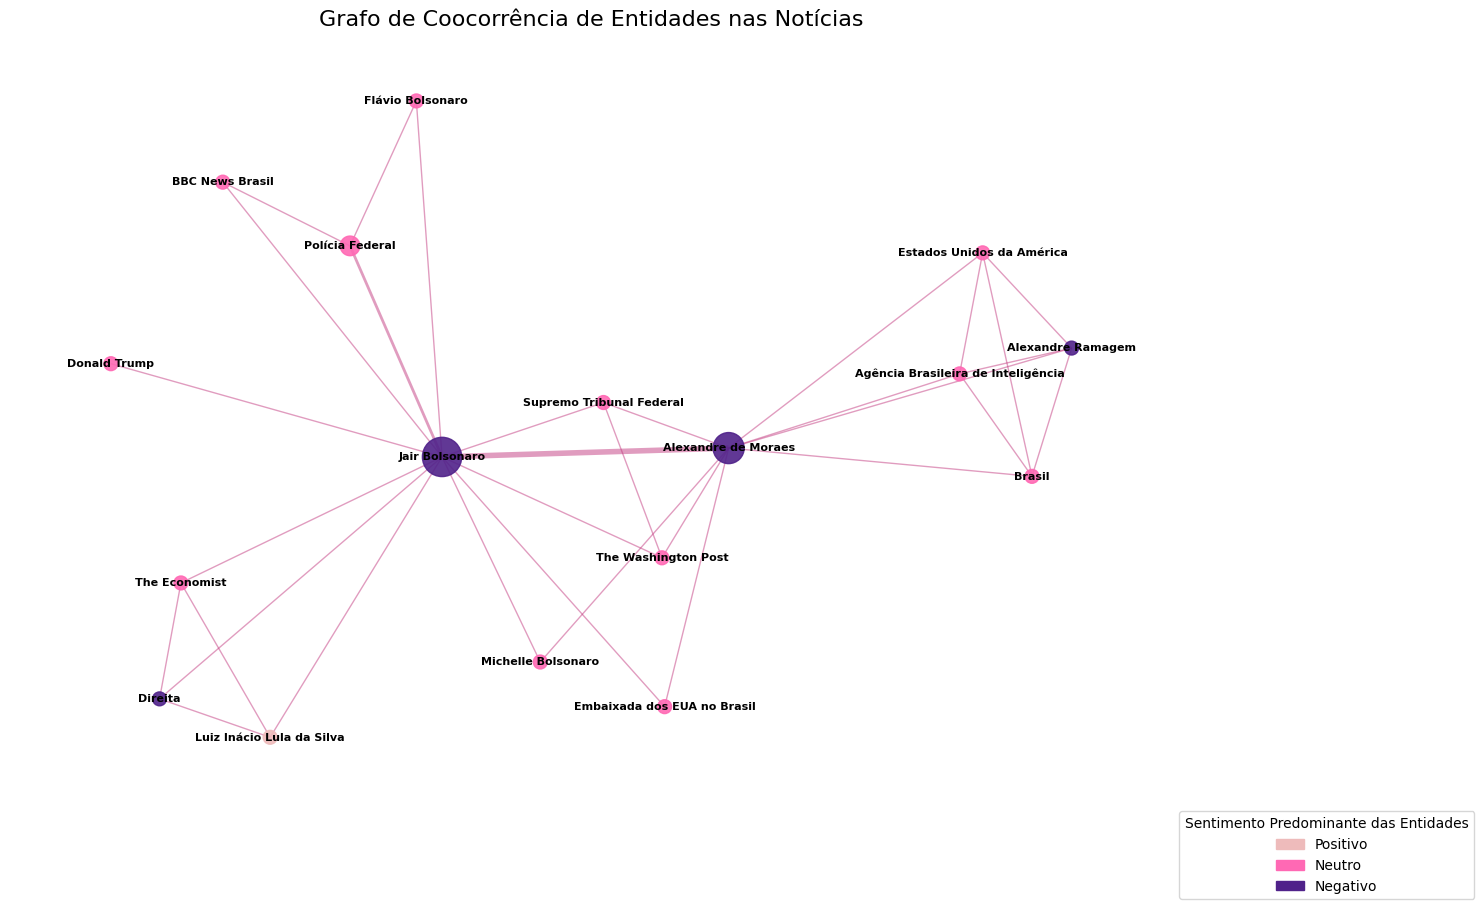

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import matplotlib.patches as mpatches

if 'df_centralizado' in locals() and not df_centralizado.empty:
    G = nx.Graph()

    # dicionario para armazenar sentimentos por entidade
    entity_overall_sentiments = {}
    entity_counts = {}

    for index, row in df_centralizado.iterrows():
        entities_str = row['entidades_detectadas']
        current_article_entities = []
        if entities_str:
            for entity_info in entities_str.split(', '):
                name_sentiment = entity_info.split(' (')
                if len(name_sentiment) == 2:
                    name = name_sentiment[0]
                    sentiment = name_sentiment[1][:-1]
                    current_article_entities.append(name)

                    # Acumular sentimentos para cada entidade
                    if name not in entity_overall_sentiments:
                        entity_overall_sentiments[name] = {'positivo': 0, 'neutro': 0, 'negativo': 0}
                    if sentiment in entity_overall_sentiments[name]:
                        entity_overall_sentiments[name][sentiment] += 1

                    entity_counts[name] = entity_counts.get(name, 0) + 1

            # Adicionar arestas
            for entity1, entity2 in combinations(current_article_entities, 2):
                if G.has_edge(entity1, entity2):
                    G[entity1][entity2]['weight'] += 1
                else:
                    G.add_edge(entity1, entity2, weight=1)

    # Atribuir sentimento predominante a cada entidade para coloração dos nós
    node_colors = []
    for node in G.nodes():
        sent_counts = entity_overall_sentiments.get(node, {'positivo': 0, 'neutro': 0, 'negativo': 0})
        if sent_counts['positivo'] > sent_counts['negativo'] and sent_counts['positivo'] >= sent_counts['neutro']:
            node_colors.append('#eebbbb') # Rosa claro para Positivo
        elif sent_counts['negativo'] > sent_counts['positivo'] and sent_counts['negativo'] >= sent_counts['neutro']:
            node_colors.append('#50228a') # Rosa escuro para Negativo
        else:
            node_colors.append('#ff69b4') # Rosa médio para Neutro ou indeciso

    # Tamanho dos nós baseado na frequência de menção
    node_sizes = [entity_counts.get(node, 1) * 100 for node in G.nodes()]
    # layout do grafo
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # largura das arestas baseada no peso (coocorrência)
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='#c33b80')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    plt.title('Grafo de Coocorrência de Entidades nas Notícias', size=16)
    plt.axis('off')


    legend_patches = [
    mpatches.Patch(color='#eebbbb', label='Positivo'),
    mpatches.Patch(color='#ff69b4', label='Neutro'),
    mpatches.Patch(color='#50228a', label='Negativo')
        ]

    plt.legend(handles=legend_patches, title='Sentimento Predominante das Entidades', loc='upper left', bbox_to_anchor=(1, 0), fontsize=10)

    plt.show()
else:
    print("Nenhum dado centralizado para construir o grafo de coocorrência.")

#### **Visualização de Sentimentos das Entidades**

Este gráfico mostra a distribuição geral dos sentimentos de todas as entidades detectadas nas notícias.

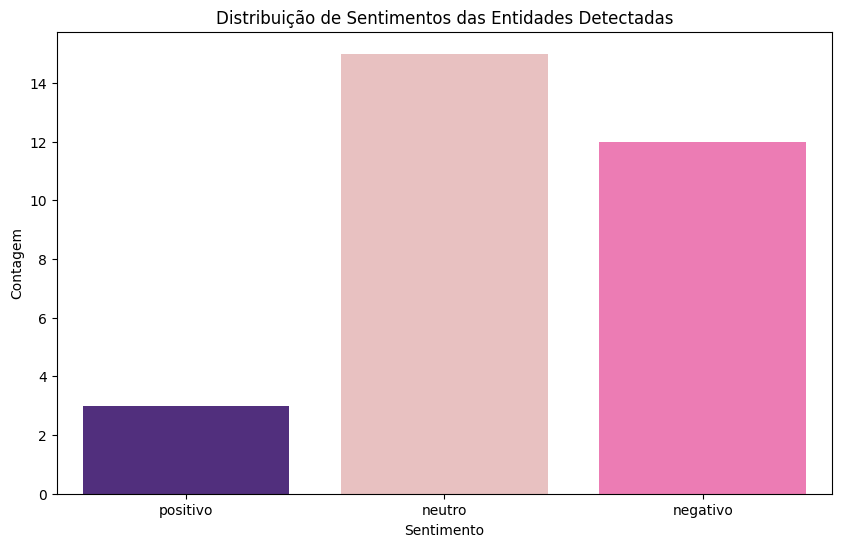

In [67]:
import seaborn as sns
all_entities_sentiments = []

if 'df_centralizado' in locals() and not df_centralizado.empty:
    for index, row in df_centralizado.iterrows():
        entities_str = row['entidades_detectadas']
        if entities_str:
            for entity_info in entities_str.split(', '):
                name_sentiment = entity_info.split(' (')
                if len(name_sentiment) == 2:
                    name = name_sentiment[0]
                    sentiment = name_sentiment[1][:-1] # remove ')'
                    all_entities_sentiments.append({'entidade': name, 'sentimento': sentiment})

df_entities_sentiments = pd.DataFrame(all_entities_sentiments)

if not df_entities_sentiments.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(x='sentimento', hue='sentimento', data=df_entities_sentiments, palette=['#eebbbb', '#ff69b4', '#50228a'], order=['positivo', 'neutro', 'negativo'])
    plt.title('Distribuição de Sentimentos das Entidades Detectadas')
    plt.xlabel('Sentimento')
    plt.ylabel('Contagem')
    plt.show()
else:
    print("Nenhuma entidade com sentimento detectado para visualização.")

#### **Análise de Entidades Mais Frequentes e Seus Sentimentos**

Esta visualização mostra as entidades que mais aparecem nas notícias e como os sentimentos (positivo, neutro, negativo) se distribuem para cada uma delas.

<Figure size 1200x700 with 0 Axes>

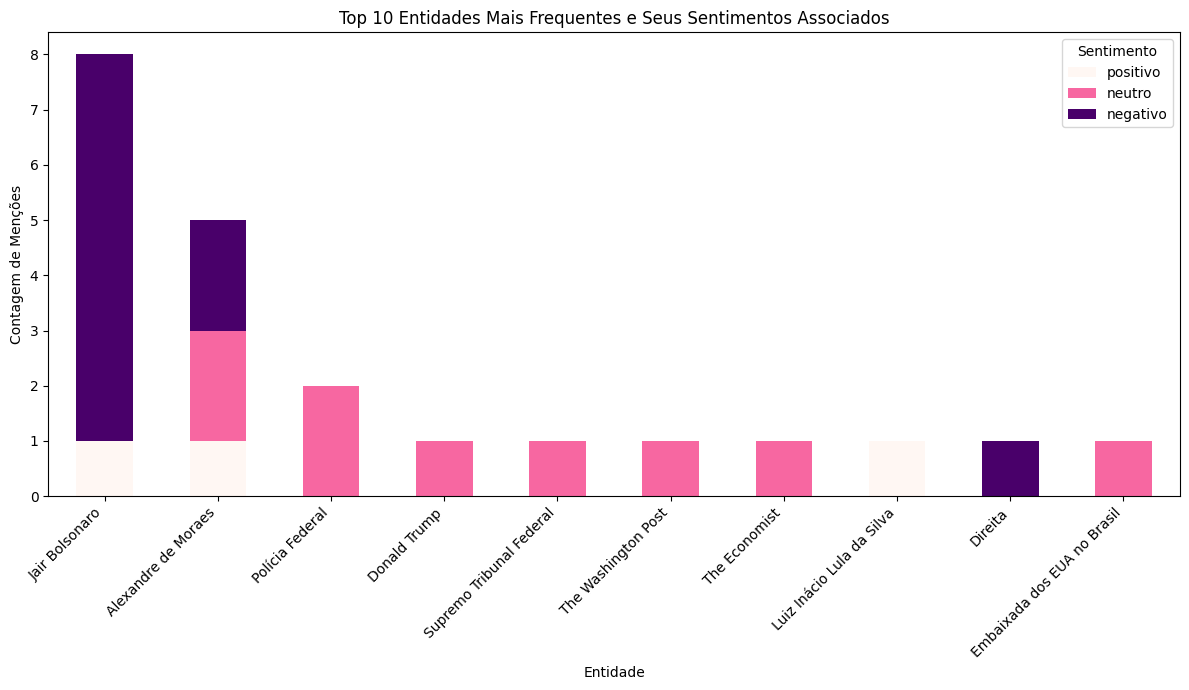

In [68]:
from collections import defaultdict

# Agrupar sentimentos por entidade
entities_sentiment_agg = defaultdict(lambda: {'positivo': 0, 'neutro': 0, 'negativo': 0})

if 'df_centralizado' in locals() and not df_centralizado.empty:
    for index, row in df_centralizado.iterrows():
        entities_str = row['entidades_detectadas']
        if entities_str:
            for entity_info in entities_str.split(', '):
                name_sentiment = entity_info.split(' (')
                if len(name_sentiment) == 2:
                    name = name_sentiment[0]
                    sentiment = name_sentiment[1][:-1]
                    if sentiment in entities_sentiment_agg[name]:
                        entities_sentiment_agg[name][sentiment] += 1

    # Converter para DataFrame para facilitar a visualização
    df_agg_entities = pd.DataFrame.from_dict(entities_sentiment_agg, orient='index')
    df_agg_entities = df_agg_entities.fillna(0).astype(int).reset_index()
    df_agg_entities.rename(columns={'index': 'entidade'}, inplace=True)

    # Calcular a frequência total para ordenar
    df_agg_entities['total'] = df_agg_entities[['positivo', 'neutro', 'negativo']].sum(axis=1)

    # Filtrar e mostrar as top N entidades
    top_n = 10
    df_top_entities = df_agg_entities.sort_values(by='total', ascending=False).head(top_n)

    if not df_top_entities.empty:
        plt.figure(figsize=(12, 7))
        df_top_entities.set_index('entidade')[['positivo', 'neutro', 'negativo']].plot(kind='bar', stacked=True, colormap='RdPu', figsize=(12,7))
        plt.title(f'Top {top_n} Entidades Mais Frequentes e Seus Sentimentos Associados')
        plt.xlabel('Entidade')
        plt.ylabel('Contagem de Menções')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Sentimento')
        plt.tight_layout()
        plt.show()
    else:
        print("Nenhuma entidade agregada para visualização.")
else:
    print("Nenhum dado centralizado para análise de entidades mais frequentes.")